In [1]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
try:
    plt.style.use('paper')
except:
    pass

In [2]:
def makesim(e=1.e-2, dtfac=0.01, integrator="whfast"):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=3.e-6, a=1., e=e)
    sim.add(m=3.e-6, a=2., e=e)
    sim.move_to_com()
    sim.integrator=integrator
    sim.dt = dtfac*sim.particles[1].P
    return sim

In [3]:
def run(times, e=1.e-2, dtfac=0.01, tmax=1.e3, integrator="whfast", get_e=False):
    sim = makesim(e=e, dtfac=dtfac, integrator=integrator)
    E0 = sim.calculate_energy()    
    Es = np.zeros(Nout)
    for i, time in enumerate(times):
        sim.integrate(time)
        E = sim.calculate_energy()
        Es[i] = np.abs((E-E0)/E0)
    return Es

In [4]:
%%time

tmax = 1.e4
e=1.e-2
dtfac = 1.e-2
Nout = 1000
times = np.logspace(0, np.log10(tmax), Nout)
    
EsWH = run(times=times, e=e, dtfac=dtfac, tmax=tmax, integrator="whfast")
EsLF = run(times=times, e=e, dtfac=dtfac, tmax=tmax, integrator="leapfrog")

CPU times: user 908 ms, sys: 6.85 ms, total: 915 ms
Wall time: 914 ms


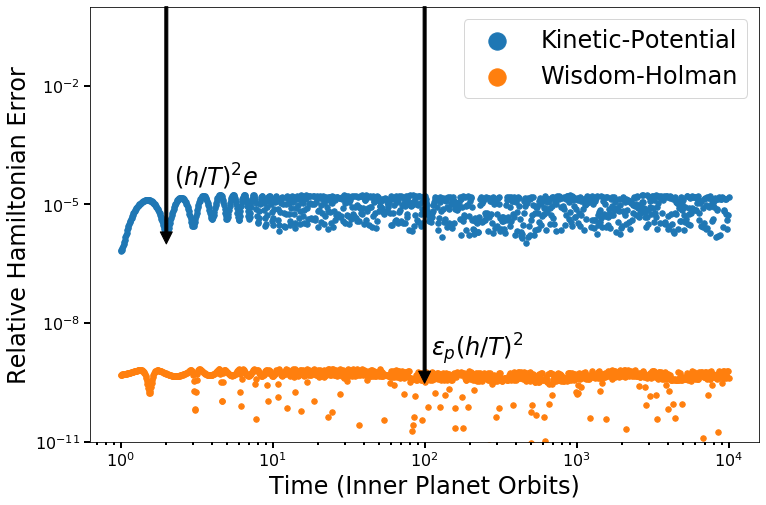

In [5]:
eps_p = 3.e-6
s = 30
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(times, EsLF, s=s, label='Kinetic-Potential')
ax.scatter(times, EsWH, s=s, label='Wisdom-Holman')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1.e-11, 1.])

plt.rcParams["text.usetex"] = False
plt.locator_params(axis='y', numticks=5)

ax.annotate(s='', xy=(2, e*dtfac**2), xytext=(2, 1), arrowprops=dict(width=3, facecolor='black'))
ax.annotate(s='', xy=(100, eps_p*dtfac**2), xytext=(100, 1), arrowprops=dict(width=3, facecolor='black'))
ax.text(2.25, 3.e-5, r'$(h/T)^2e$', fontsize=24)
ax.text(110, 1.5e-9, r'$\epsilon_{p}(h/T)^2$', fontsize=24)

ax.set_xlabel('Time (Inner Planet Orbits)', fontsize=24)
ax.set_ylabel('Relative Hamiltonian Error', fontsize=24)

lgnd = ax.legend(fontsize=24,loc='upper right', scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([300])
    
fig.savefig("fig1.pdf", bbox_inches='tight')